In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nbformat

import openai
import tiktoken
# import time

from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde

import dotenv

In [2]:
dotenv.load_dotenv()

# openai.api_key = os.getenv('OPENAI_API_KEY')

True

### Data Import

The source data for this project is located here:

http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz


In [ ]:
data_path = './../data/raw/20news-bydate/20news-bydate-train'

In [ ]:
# get list of category directories
categories = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

categories

Create lists to store the texts and corresponding categories.

In [ ]:
texts = []
labels = []

Loop through each category directory to read the text files and assign the appropriate label.

In [ ]:
for category in categories:
    category_path = os.path.join(data_path, category)

    # import all text files in the current category folder
    file_paths = glob.glob(os.path.join(category_path, '*'))

    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            text = file.read()
            texts.append(text)
            labels.append(category)


Create data frame

In [ ]:
df = pd.DataFrame({'text': texts, 'category': labels})

In [ ]:
print(f"Imported {len(df)} documents.")

Export data frame

In [ ]:
df.to_csv('./../data/processed/train.csv')

Examining the first text file's structure

In [ ]:
print(df['text'][0])

### Generate Embeddings

In [ ]:
client = openai.OpenAI(
    api_key=os.getenv('OPENAI_API_KEY')
)

In [ ]:
def get_embedding(text):
    response = client.embeddings.create(input=text, model="text-embedding-3-large")

    return response.data[0].embedding

Add embeddings to data frame

In [ ]:
embeddings = []

for idx, text in enumerate(df['text']):
    try:
        embedding = get_embedding(text)
    except Exception as e:
        print(f"Error generating embedding for index {idx}: {e}")
    
    embeddings.append(embedding)

    # if necessary ... short delay to avoid API rate limits
    # time.sleep(0.1)

Define function to truncate documents that are longer than the 8192 token context limit.

In [ ]:
def truncate_text(text, max_tokens=8192, encoding_name="cl100k_base"):
    """
    Truncates the text to a maximum number of tokens using the tiktoken library.

    Example usage:

    df['truncated_text'] = df['text'].apply(lambda t: truncate_text(t, max_tokens=8192))
    """

    encoding = tiktoken.get_encoding(encoding_name=encoding_name)

    tokens = encoding.encode(text)

    if len(tokens) <= max_tokens:
        return(text)
    else:
        # Truncate tokens to max_tokens
        truncated_tokens = tokens[:max_tokens]
        text = encoding.decode(truncated_tokens)
    
    return text


# alternate quick & dirty option
def quick_truncate(text, max_tokens):
    """
    Example usage:
    df['truncated_text'] = df['text'].apply(quick_truncate)
    """
    max_chars = max_tokens*4
    return text[:max_chars]

Add document embeddings to data frame.

In [ ]:
df['embedding'] = embeddings

Export data frame as pickle file

In [ ]:
df.to_pickle('./../data/processed/training_data_with_embeddings.pkl')

#### Re-Import Processed Data

In [ ]:
df = pd.read_pickle('./../data/processed/train_with_embeddings.pkl')

#### Conduct Principal Component Analysis

First, convert embeddings to a NumPy array

In [4]:
embedding_array = np.array(df['embedding'].tolist())

Next, initialize and fit PCA to reduce to 2 dimensions.

In [5]:
pca = PCA(n_components=2)

components = pca.fit_transform(embedding_array)

Add the new components as X and Y columns in the data frame. (Labeling them as "x_2d" for the x coordinate and "y_2d" in case I later decide to experiment with 3 dimensions).

In [6]:
df['x_2d'] = components[:, 0]
df['y_2d'] = components[:, 1]

#### Generate Kernel Density Estimates

Group the data by category and convert the 2D coordinates to a 2 x n array for each group.

In [7]:
kdes = {}

categories = df['category'].unique()

for cls in categories:
    subset = df[df['category'] == cls]

    # create a 2 x n_points array with x and y coordinates

    points = np.vstack([subset['x_2d'], subset['y_2d']])

    kdes[cls] = gaussian_kde(points)

Define a grid over the embedding space using the `x_2d` and `y_2d` columns

In [8]:
xmin, xmax = df['x_2d'].min() - 1, df['x_2d'].max() + 1
ymin, ymax = df['y_2d'].min() - 1, df['y_2d'].max() + 1

grid_size = 100  # resolution of the grid
xgrid = np.linspace(xmin, xmax, grid_size)
ygrid = np.linspace(ymin, ymax, grid_size)
X, Y = np.meshgrid(xgrid, ygrid)
grid_coords = np.vstack([X.ravel(), Y.ravel()])  # shape: (2, grid_size^2)

Evaluate each class' KDE on the grid

In [9]:
density = {}

for cls, kde in kdes.items():
    # evaluate the KDE on the grid and reshape back to grid form

    density[cls] = kde(grid_coords).reshape(X.shape)

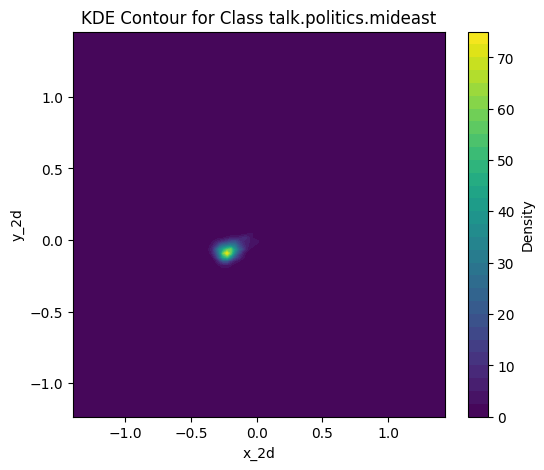

In [10]:
# Visualize the KDE for one of the classes
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, density[categories[0]], levels=30, cmap='viridis')
plt.title(f"KDE Contour for Class {categories[0]}")
plt.xlabel("x_2d")
plt.ylabel("y_2d")
plt.colorbar(label="Density")
plt.show()

#### Compute KDE Overlap Coefficient

Determine the area element (dx * dy):

In [11]:
dx = xgrid[1] - xgrid[0]
dy = ygrid[1] - ygrid[0]

Loop over all pairs of classes using sorted category labels.

In [12]:
overlap_results = {}

classes = sorted(density.keys())

for i in range(len(classes)):
    for j in range(i + 1, len(classes)):
        cls1 = classes[i]
        cls2 = classes[j]

        # compute the pointwise minimum of the two density grids
        min_density = np.minimum(density[cls1], density[cls2])

        # approximate the integral over the grid as the sum of the minimum density
        overlap_coef = np.sum(min_density) * dx * dy

        overlap_results[(cls1, cls2)] = overlap_coef
        print(f"Overlap coefficient between class {cls1} and {cls2}: {overlap_coef:.4f}")

Overlap coefficient between class alt.atheism and comp.graphics: 0.0095
Overlap coefficient between class alt.atheism and comp.os.ms-windows.misc: 0.0030
Overlap coefficient between class alt.atheism and comp.sys.ibm.pc.hardware: 0.0010
Overlap coefficient between class alt.atheism and comp.sys.mac.hardware: 0.0027
Overlap coefficient between class alt.atheism and comp.windows.x: 0.0087
Overlap coefficient between class alt.atheism and misc.forsale: 0.0143
Overlap coefficient between class alt.atheism and rec.autos: 0.0875
Overlap coefficient between class alt.atheism and rec.motorcycles: 0.0524
Overlap coefficient between class alt.atheism and rec.sport.baseball: 0.0024
Overlap coefficient between class alt.atheism and rec.sport.hockey: 0.0003
Overlap coefficient between class alt.atheism and sci.crypt: 0.1883
Overlap coefficient between class alt.atheism and sci.electronics: 0.0253
Overlap coefficient between class alt.atheism and sci.med: 0.1424
Overlap coefficient between class alt

In [13]:
classes = sorted(df['category'].unique())
n_classes = len(classes)

overlap_matrix = np.full((n_classes, n_classes), np.nan)

# fill the matrix with the computed overlaps
for (cls1, cls2), coef in overlap_results.items():
    # find the index for each class in the sorted list
    i = classes.index(cls1)
    j = classes.index(cls2)

    overlap_matrix[i, j] = coef
    # overlap_matrix[j, i] = coef # optional: leaving this out for now to create an upper diagonal matrix

# set the diagonal to 1
# np.fill_diagonal(overlap_matrix, 1) # skipping this for now as the diagonal grabs too much attention

# create DF with labels for the heat map
df_overlap = pd.DataFrame(overlap_matrix,
                          index=[f"{c}" for c in classes],
                          columns=[f"{c}" for c in classes]
                          )


Plot the heat map

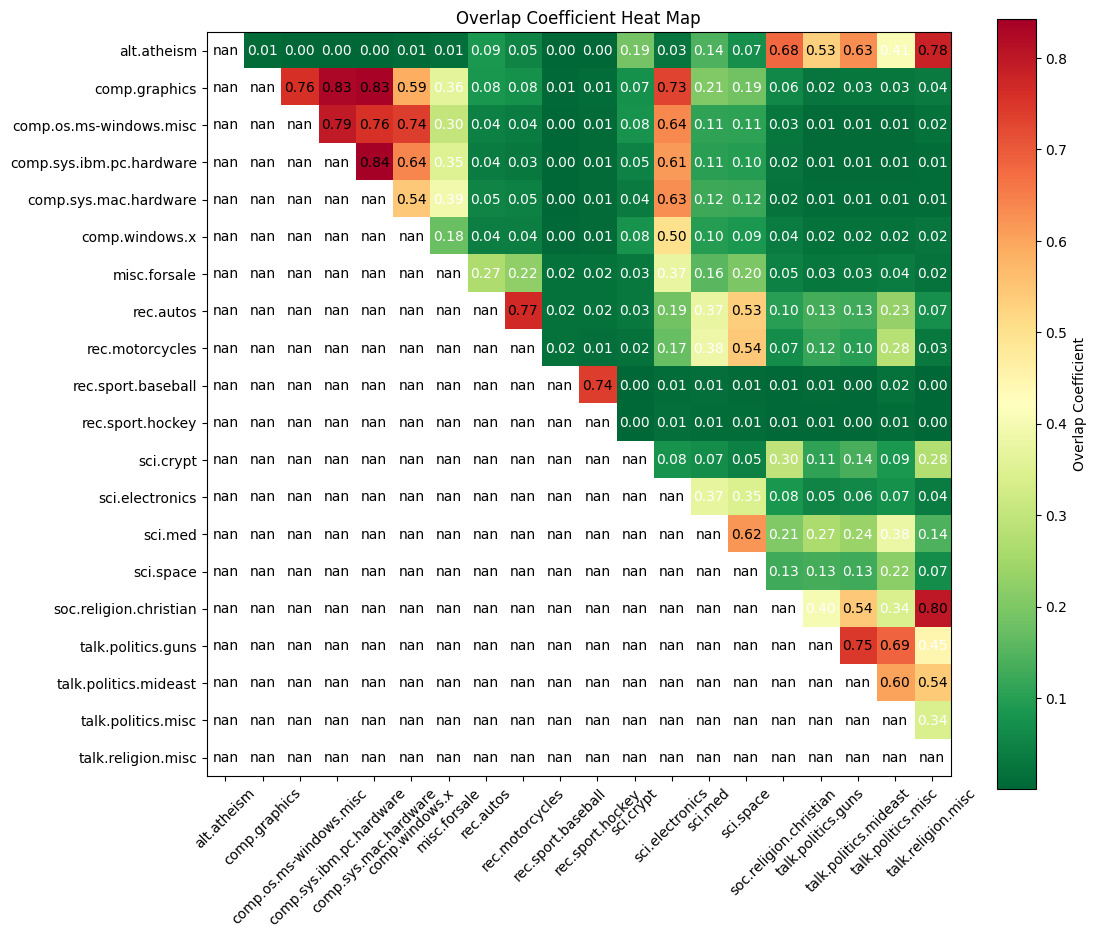

In [14]:
# Plot the heat map
plt.figure(figsize=(12, 10))
plt.imshow(df_overlap, cmap='RdYlGn_r', interpolation='nearest')
plt.title("Overlap Coefficient Heat Map")
plt.colorbar(label="Overlap Coefficient")
plt.xticks(ticks=np.arange(n_classes), labels=[f"{c}" for c in classes], rotation=45)
plt.yticks(ticks=np.arange(n_classes), labels=[f"{c}" for c in classes])

# Annotate each cell with the overlap value (rounded to 2 decimal places)
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, f"{df_overlap.iloc[i, j]:.2f}",
                 ha="center", va="center",
                 color="white" if df_overlap.iloc[i, j] < 0.5 else "black")

plt.show()

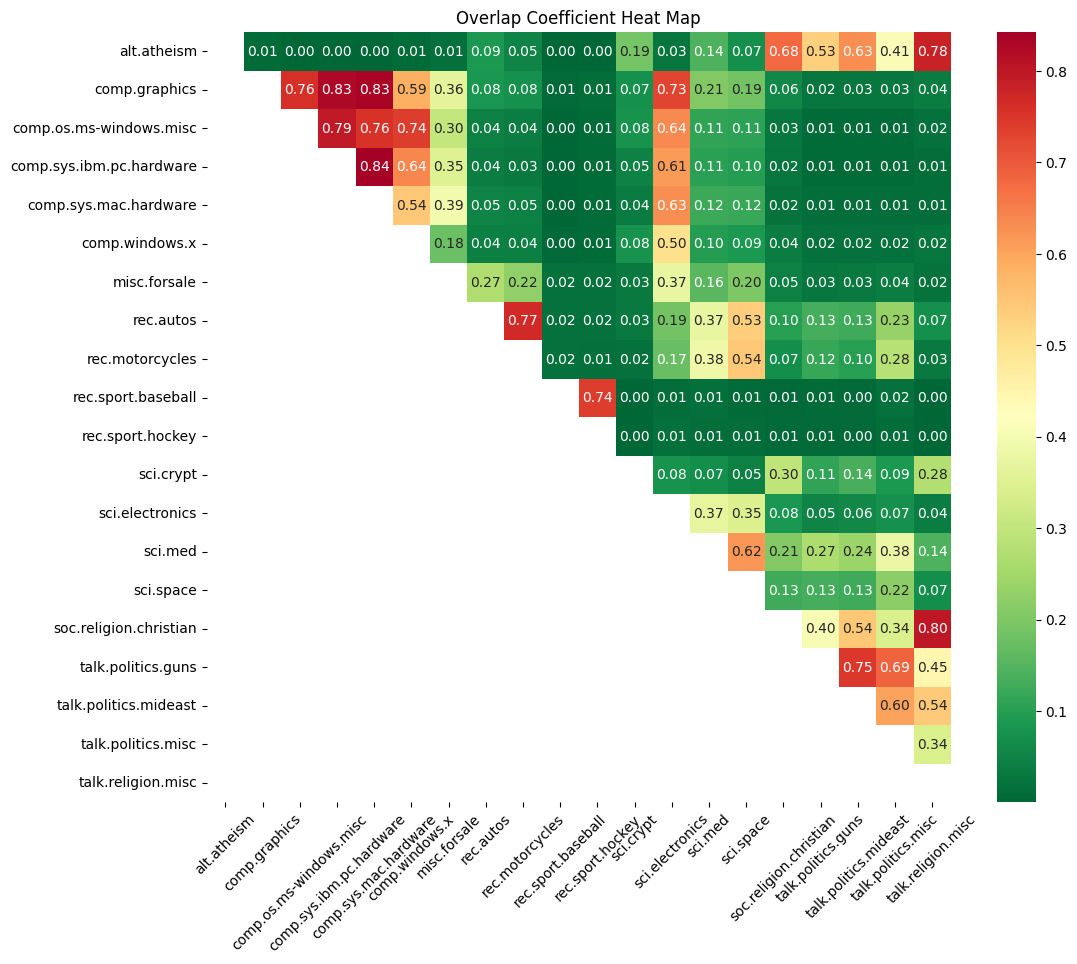

In [15]:
plt.figure(figsize=(12, 10))

ax = sns.heatmap(df_overlap, annot=True, fmt=".2f", cmap="RdYlGn_r", cbar=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.title("Overlap Coefficient Heat Map")
plt.show()

In [ ]:
fig = px.imshow(df_overlap,
                text_auto='.2f',
                color_continuous_scale='RdYlGn_r',
                aspect='auto',
                title="Overlap Coefficient Heat Map",
                height=800,
                width=1000,
                template="ggplot2"
                )

fig.update_xaxes(tickangle=45)

fig.show()

In [28]:
import plotly.io as pio
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

The 'colorscale' property is a colorscale and may be
    specified as:
      - A list of colors that will be spaced evenly to create the colorscale.
        Many predefined colorscale lists are included in the sequential, diverging,
        and cyclical modules in the plotly.colors package.
      - A list of 2-element lists where the first element is the
        normalized color level value (starting at 0 and ending at 1),
        and the second item is a valid color string.
        (e.g. [[0, 'green'], [0.5, 'red'], [1.0, 'rgb(0, 0, 255)']])
      - One of the following named colorscales:
            ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
             'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
             'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
             'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
             'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
             'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
             'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
             'ylorrd'].
        Appending '_r' to a named colorscale reverses it.

In [1]:
import sys
sys.path.append('../src')

from embedding_functions import *

In [2]:
sample_text = 'I am the very model of a modern major general.'

In [3]:
truncate_text(sample_text, max_tokens=8)

'I am the very model of a modern'

In [ ]:
relative_path = os.path.abspath('.')
sys.path.append(relative_path)

from src.embedding_functions import *